# Machine Learning LAB 4: CLUSTERING - K-means and linkage-based clustering

Course 2024/25: *M. Caligiuri*, *M. Pavan*, *P. Zanuttigh*

The notebook contains some simple clustering exercises.



## Image segmentation with k-means

In this laboratory we will use the k-means algorithm to cluster a dataset of 3D points that represent image pixels. We will apply **K-means** to the problem of image segmentation. The main idea is to apply k-means to the colors of the pixels of an image to select the k most representative colors. Then, we will replace each pixel color with the closest representative color. This will allow us to reduce the number of colors in the image and produce a segmentation map of it (it also allows to reduce the amount of data to store the image, can be also used for image compression!). A color is a vector of 3 values (R,G,B) that represent the amount of red, green and blue in the color; this implies that each pixel is a point in a 3D space.

In particular you are going to implement the k-means algorithm from scratch and to compare the results with the implementation already present in the sklearn library.

In the second part of the laboratory we will use a **linkage-based** clustering algorithm to cluster a dataset of 2D points and compare it with the results obtained with k-means.

---

## Preliminary step

Place your **name** and **ID number** (matricola) in the cell below. <br>


**Student name**: Marco Malanchin

**ID Number**: 2101573

---

## Import all the necessary Python libraries

In [1]:
%matplotlib inline  

import numpy as np
import typing as tp
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from matplotlib import pyplot as plt

---

## Define the heplper functions

In this section you will find some helper functions (some already implemented, some to be implemented by you) that will be used in the following sections.
1. `img_plot` -> function to plot an image with name and dimension as title,
2. `scatter_plot` -> function to plot a scatter plot of the data,
3. `scatter_plot_2d` -> function to plot a 2D scatter plot of the data,
4. `error_plot` -> function to plot the error of the k-means algorithm over the iterations,
5. `cluster_plot` -> function to plot the obtained clusters.

**DO NOT CHANGE THE PRE-WRITTEN CODE UNLESS OTHERWISE SPECIFIED**

In [2]:
def img_plot(img: np.ndarray, title: str = None) -> None:
    """
    Plot an image
    :param img: image to plot
    :param title: title of the plot
    """
    
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    if title is not None:
        plt.title(f'{title}: {img.shape}')
    plt.tight_layout()
    plt.show()
    plt.close()

In [3]:
def scatter_plot(data: np.ndarray, clusters: np.ndarray = None, centers: np.ndarray = None, title: str = None) -> None:
    """
    Plot a scatter plot of the data
    :param data: data to plot
    :param clusters: cluster labels
    :param centers: cluster centers
    :param title: title of the plot
    """
    
    fig = plt.figure()
    axis = fig.add_subplot(1, 1, 1, projection="3d")
    axis.set_xlabel("Red")
    axis.set_ylabel("Green")
    axis.set_zlabel("Blue", rotation=90, labelpad=-1)
    if title is not None:
        plt.title(title)
    if clusters is None:
        axis.scatter(data[:,0], data[:,1], data[:,2], marker="o", c=data, s=5)
    else:
        axis.scatter(data[:,0], data[:,1], data[:,2], marker="o", c=clusters, s=1, cmap='viridis', zorder=0, alpha=0.5 )
    if centers is not None:
        axis.scatter(centers[:,0], centers[:,1], centers[:,2], c='red', s=400, zorder=10)
    plt.tight_layout()
    plt.show()
    plt.close()

In [4]:
def scatter_plot_2d(x: np.ndarray, y: np.ndarray = None, centers: np.ndarray = None, title: str = None) -> None:
    """
    Plot a scatter plot of the data
    :param x: data to plot
    :param y: cluster labels
    :param centers: cluster centers
    :param title: title of the plot
    """

    fig = plt.figure()
    plt.scatter(x[:,0], x[:,1], c=y, marker="o", s=10, cmap='viridis')
    plt.scatter(centers[:,0], centers[:,1], c='black', s=200, alpha=0.5)
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.close()

In [5]:
def error_plot(errors: np.ndarray, labels: np.ndarray = None) -> None:
    """
    Plot the errors over the iterations
    :param errors: errors to plot
    """
    
    if labels is None:
        plt.plot(errors[1:-1])
        plt.plot(errors[1:-1], 'ro')
    else:
        plt.plot(labels, errors)
        plt.plot(labels, errors, 'ro')
    plt.title('Error over iterations')
    plt.ylabel('Error')
    plt.xlabel('Iteration #')
    plt.grid()
    plt.tight_layout()
    plt.show()
    plt.close()

In [6]:
def cluster_plot(labels: np.ndarray, x: np.ndarray, title: str = None) -> None:
    """
    Plot the clusters
    :param labels: cluster labels
    :param x: data
    :param title: title of the plot
    """
    
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
            for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = x[class_member_mask ]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=14)

        xy = x[class_member_mask ]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=6)

    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.close()

---

## A) K-means clustering

### TO DO (A.0)
    
**Set** the random **seed** using your **ID**. If you need to change it for testing add a constant explicitly, eg.: 1234567 + 1

In [7]:
# Fix your ID ("numero di matricola") and the seed for random generator
# as usual you can try different seeds by adding a constant to the number:
# ID = 1234567 + X
ID = 2101573  # insert your ID number here
np.random.seed(ID)

Load the provided images and display them (if you like you can experiment with other images)

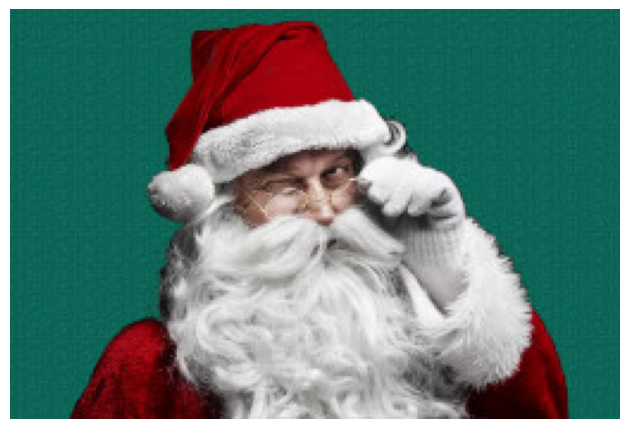

In [21]:
# To load the images use the function plt.imread(<path_to_image>)
# ADD YOUR CODE HERE
data = plt.imread("data/santaclaus2.jpg")

# Plot the images with their shapes
# Sugestion: use the function img_plot()
# ADD YOUR CODE HERE
img_plot(data)

We are going to start by using the Santa Claus image.


In [22]:
# Reshape the data to a matrix of num_pixels x 3 
# (divide by 255 to have colors in [0 1] range for plotting functions of sklearn)
# ADD YOUR CODE HERE
pixels = data.reshape(-1, 3) #-1 dice a NumPy: "calcola tu automaticamente quante righe servono"

if pixels.max() > 1.0:
    pixels = pixels / 255.0

# Print the shape of the data and the min and max values of the pixels
# ADD YOUR CODE HERE
print(pixels)
print(pixels.max())
print(pixels.min())

[[0.05490196 0.4        0.34509804]
 [0.05098039 0.39607843 0.34117647]
 [0.05098039 0.39607843 0.34117647]
 ...
 [0.05882353 0.40392157 0.34901961]
 [0.05882353 0.40392157 0.34901961]
 [0.05882353 0.40392157 0.34901961]]
1.0
0.0


Plot the points in the 3-dimensional space with normalized intervals between 0 and 1 (corresponding to the three channels of the image, i.e. Red Green and Blue)

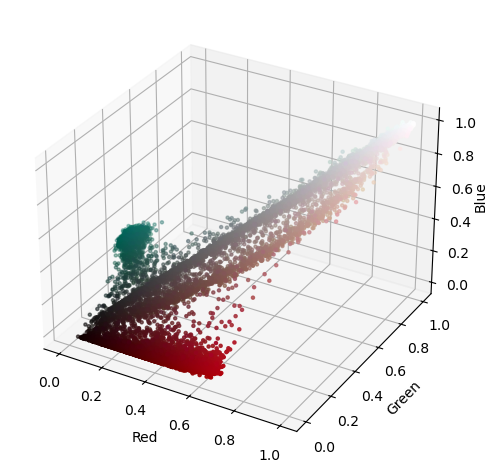

In [23]:
# Sugestion: use the function scatter_plot()
# ADD YOUR CODE HERE
scatter_plot(pixels)

### TO DO (A.1)
Implement the k-means algorithm manually (**for this step do not use the k-means function of sklearn**). The inputs to the function is the set of vectors to be clustered and the number of clusters. The output must contain the clusters barycenters, a vector associating each data point to the corresponding cluster and the error (value of the cost function) at each iteration.
Additionally, fix a maximum number of iterations of the k-means algorithm (e.g., 50).

Be careful about the initalization, you can use some random points from the training set, or get random values but ensure they are in the proper range. Poor initalizations can lead to the failure of the algorithm (in particular check that no cluster is initialized as empty, otherwise the algorithm can not update it).

In [30]:
import numpy as np
import typing as tp

def my_kmeans(points: np.ndarray, k: int, max_iters: int = 50) -> tp.Tuple[np.ndarray, np.ndarray, list]:
    """
    Perform K-means clustering
    :param points: data points (shape: n_samples x n_features)
    :param k: number of clusters
    :param max_iters: maximum number of iterations
    :return: (final centroids, cluster labels, error history)
    """
    
    n_samples, n_features = points.shape
    min_vals = points.min(axis=0)
    max_vals = points.max(axis=0)

    # Inizializza centroidi casuali
    centroids = np.random.uniform(low=min_vals, high=max_vals, size=(k, n_features))

    error = []
    prev_error = float('inf')
    iters = 0

    while iters < max_iters:
        # 1. Calcola la distanza tra tutti i punti e tutti i centroidi
        distances = np.linalg.norm(points[:, np.newaxis, :] - centroids[np.newaxis, :, :], axis=2)

        # 2. Assegna ogni punto al centroide più vicino
        clusters = np.argmin(distances, axis=1)

        # 3. Calcola nuovi centroidi
        new_centroids = np.array([
            points[clusters == j].mean(axis=0) if np.any(clusters == j) else centroids[j]
            for j in range(k)
        ])

        # 4. Calcola errore (somma delle distanze quadrate)
        curr_error = np.sum((points - new_centroids[clusters])**2)
        error.append(curr_error)

        # 5. Verifica convergenza
        if np.allclose(curr_error, prev_error):
            break

        # 6. Aggiorna
        centroids = new_centroids
        prev_error = curr_error
        iters += 1

    return centroids, clusters, error

### TO DO (A.2)

Now try the function you developed on the Santaclaus image with three clusters (k=3). 

Then plot the data points in the 3-dimensional space, each point must be coloured based on the membership to one of the clusters. Additionally, plot the respective clusters centroids (use a different shape, size or color to highlight the centroids).

[np.float64(2534.1067647913646), np.float64(2527.348375839501), np.float64(2527.2163188063755), np.float64(2527.2155941754536)]


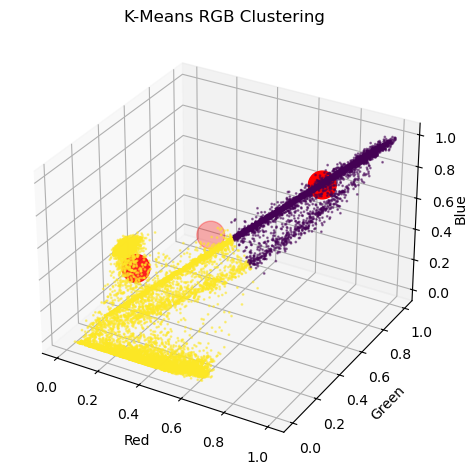

In [32]:
# Run your K-means function on the data
# ADD YOUR CODE HERE
centroids, labels, errors = my_kmeans(pixels, 3)

# Print the errors:
# ADD YOUR CODE HERE
print(errors)

# Plot the results
# ADD YOUR CODE HERE
scatter_plot(pixels, clusters=labels, centers=centroids, title="K-Means RGB Clustering")

### TO DO (A.3) 
Plot the value of the error versus the number of iterations

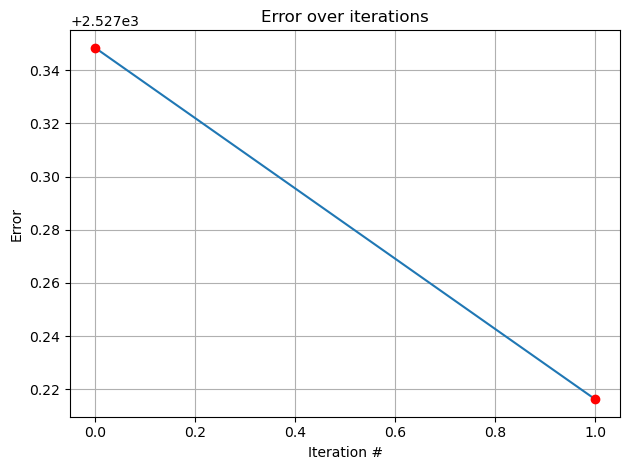

In [33]:
# Sugestion: use the function error_plot()
# ADD YOUR CODE HERE
error_plot(errors)

### TO DO (A.4)
Now use the k-means function provided in sklearn. Pass to the function the number of clusters and use multiple random initializations (n_init parameter). Go to the documentation page for further details

In [34]:
# Define the K-means model
k = 5  # Numero di cluster desiderato
model = KMeans(n_clusters=k, random_state=42)

# Fit the model to the data
model.fit(pixels)

# Get the cluster centers
sk_centroids = model.cluster_centers_

# Get the labels (a quale cluster appartiene ogni pixel)
sk_labels = model.labels_

Perform the same plot as above but with the output of the k-means function provided in sklearn.

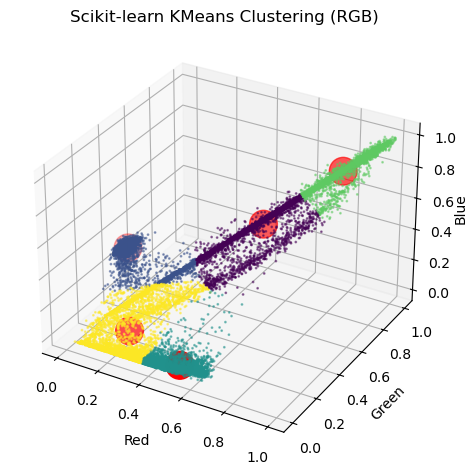

In [35]:
# ADD YOUR CODE HERE
scatter_plot(pixels, clusters=sk_labels, centers=sk_centroids, title="Scikit-learn KMeans Clustering (RGB)")


### TO DO (A.Q1) [Answer the following] 

Compare the results obtained with your implementation and with k-means from sklearn. Do you observe any differences, *i.e.*, do the two plots match?

**ANSWER A.Q1:** Answer here

### TO DO (A.5)

Now display the segmented image based on the two clusters found above with the k-means functions by sklearn.

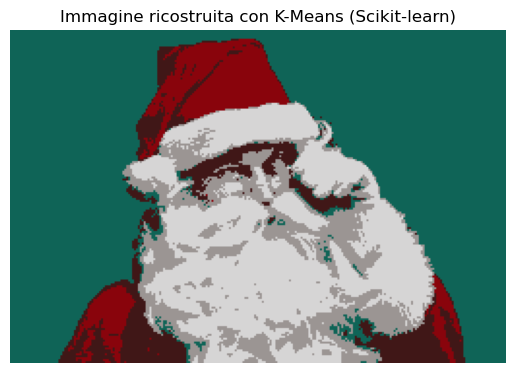

In [36]:
# 1. Estrai i colori dei centroidi
recolored_pixels = sk_centroids[sk_labels]

# 2. Ricostruisci la forma originale dell'immagine
recolored_image = recolored_pixels.reshape(data.shape)

# 3. Mostra immagine compressa
plt.imshow(recolored_image)
plt.axis('off')
plt.title("Immagine ricostruita con K-Means (Scikit-learn)")
plt.show()

Now display the segmented image based on the two clusters found above with the k-means functions implemented by yourselves.

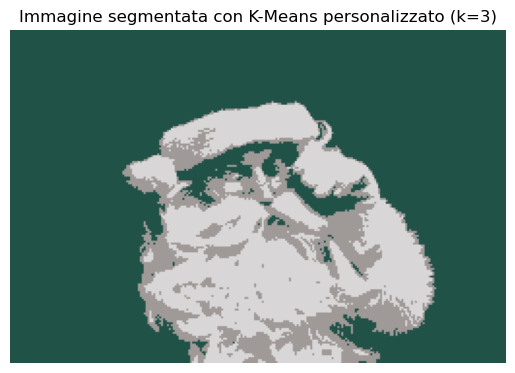

In [39]:
# Esegui la tua funzione di K-means con k=3
centroids, labels, error = my_kmeans(pixels, k=3)

# Ricostruisci i colori dei pixel basati sui centroidi
recolored_pixels = centroids[labels]

# Ricostruisci l'immagine con la forma originale
segmented_image = recolored_pixels.reshape(data.shape)

# Mostra l'immagine segmentata
plt.imshow(segmented_image)
plt.axis('off')
plt.title("Immagine segmentata con K-Means personalizzato (k=3)")
plt.show()

### TO DO (A.6)

Now load the landscape image (optional: try also with the reindeer image) and segment it using kmeans with k varying from 2 to 15 clusters. You can use the sklearn implementation.

Then plot the resulting data points in the 3-dimensional space, each point must be colored based on the cluster membership.

Shape dei pixel: (44032, 3)
Valore minimo: 0.0
Valore massimo: 1.0

K-means clustering with different values of K (2-15):

K = 2


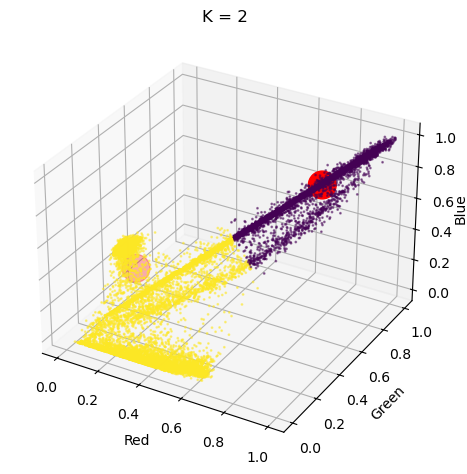

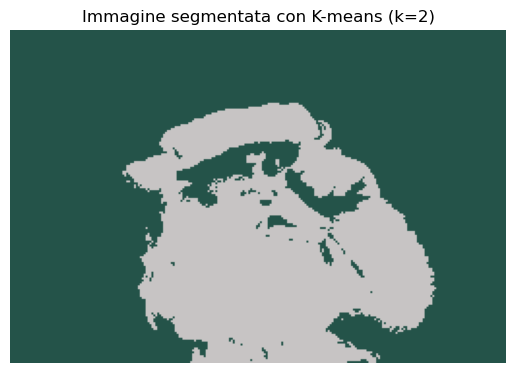


K = 3


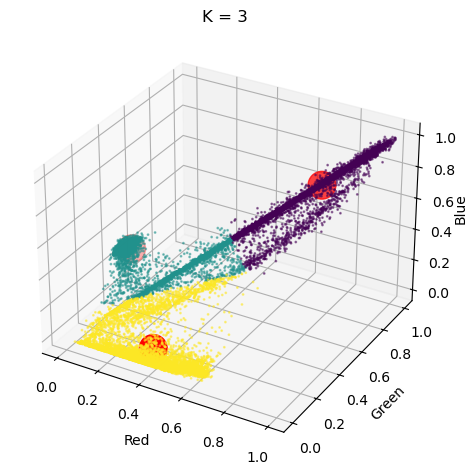

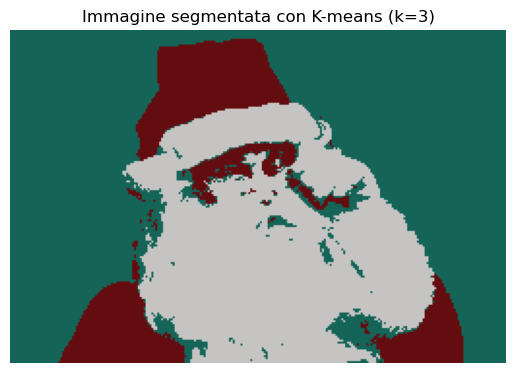


K = 4


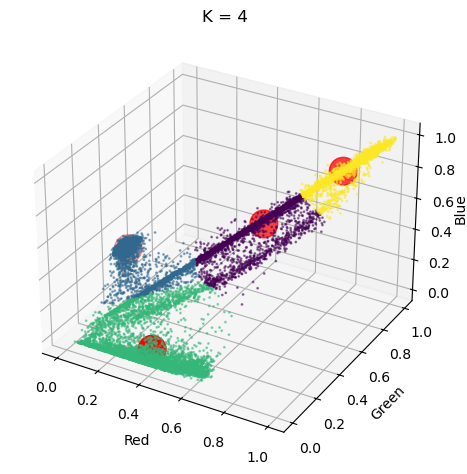

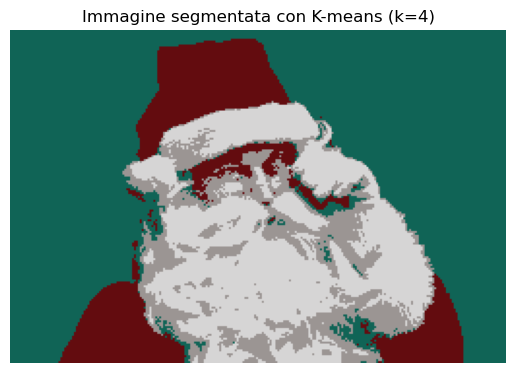


K = 5


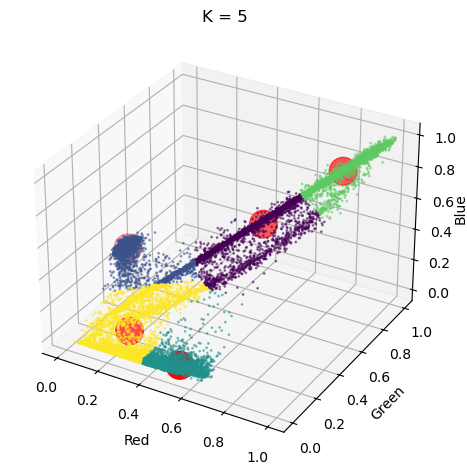

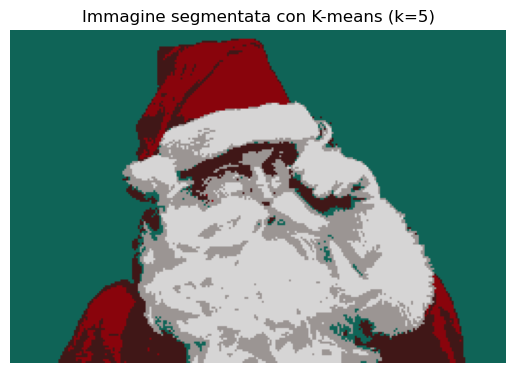


K = 6


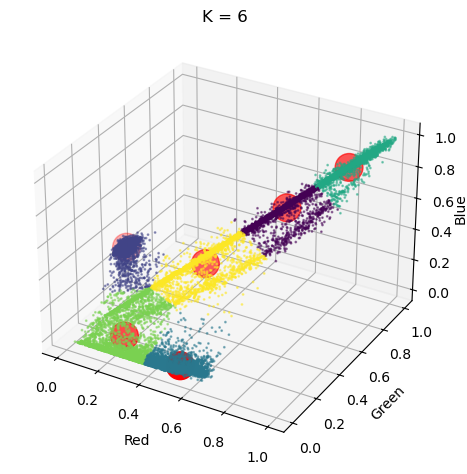

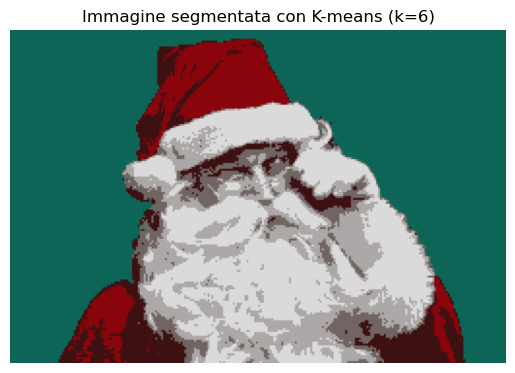


K = 7


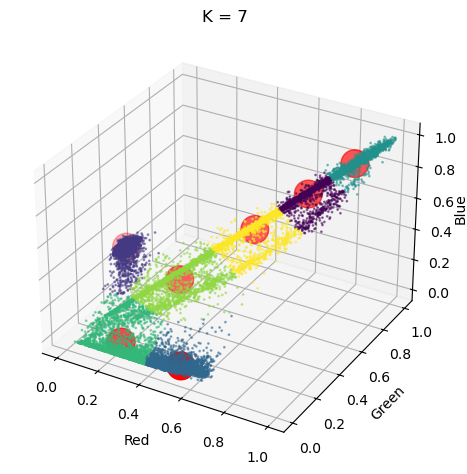

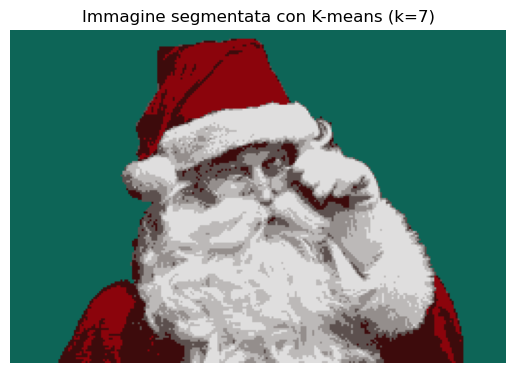


K = 8


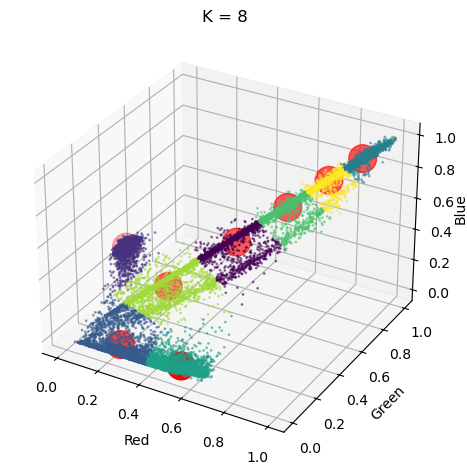

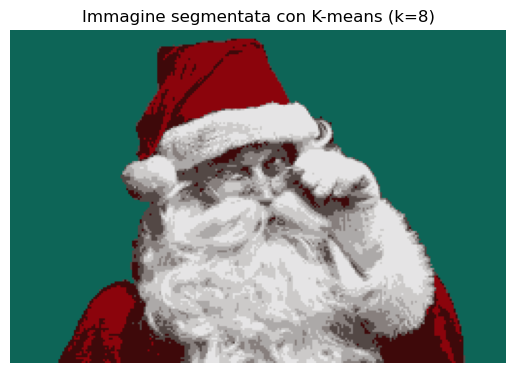


K = 9


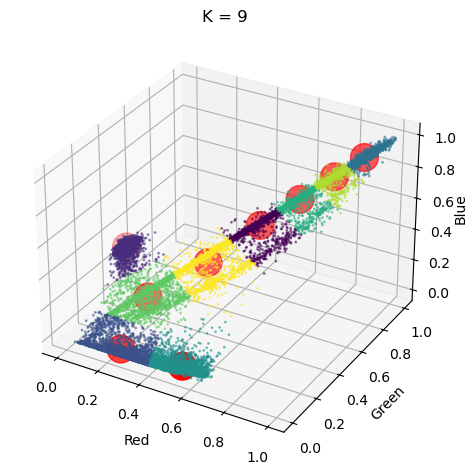

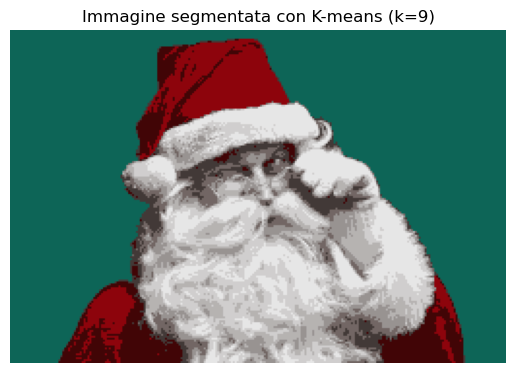


K = 10


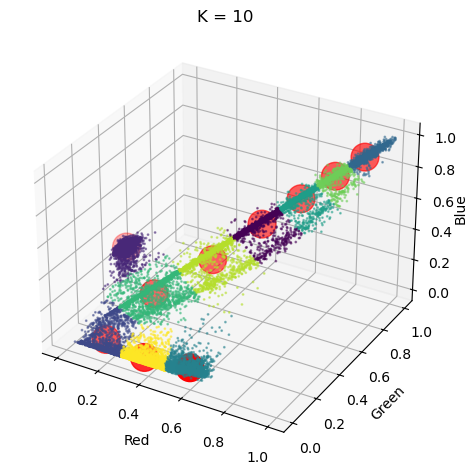

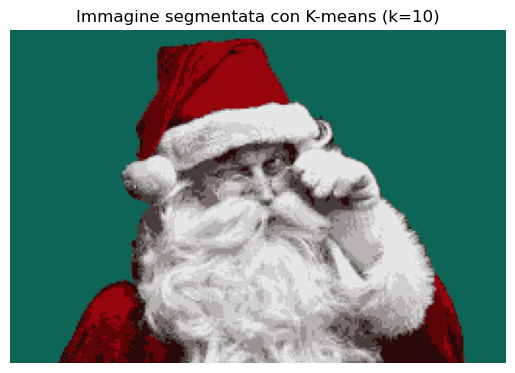


K = 11


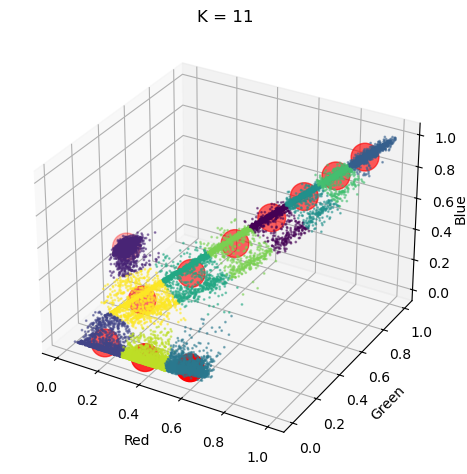

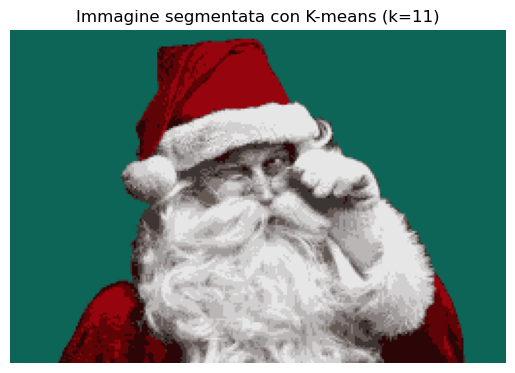


K = 12


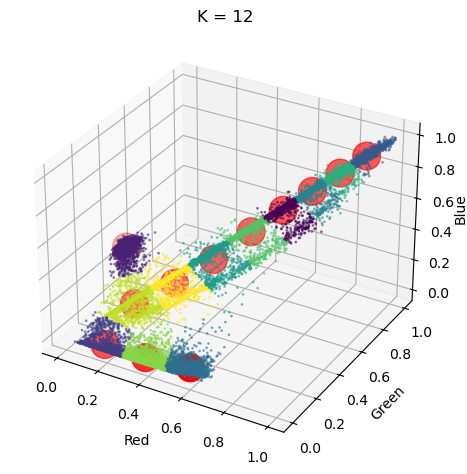

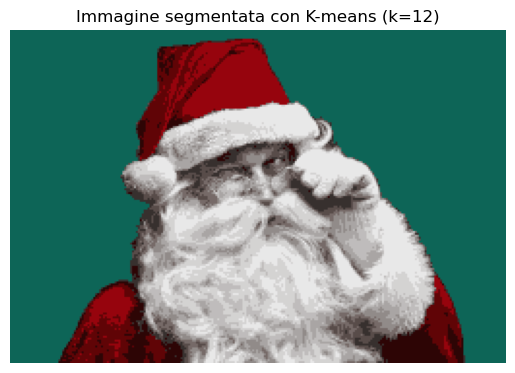


K = 13


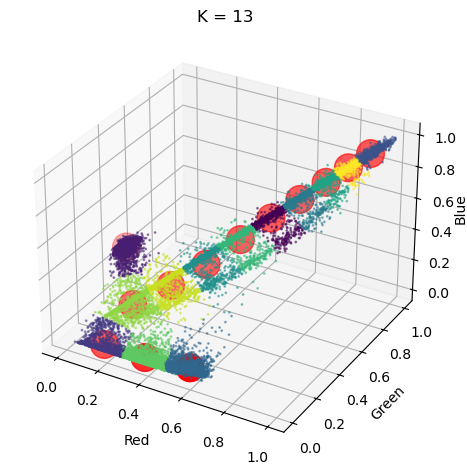

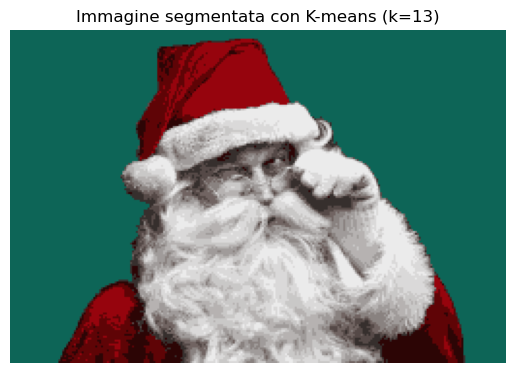


K = 14


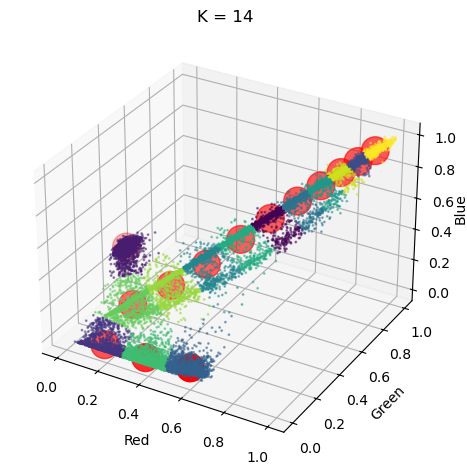

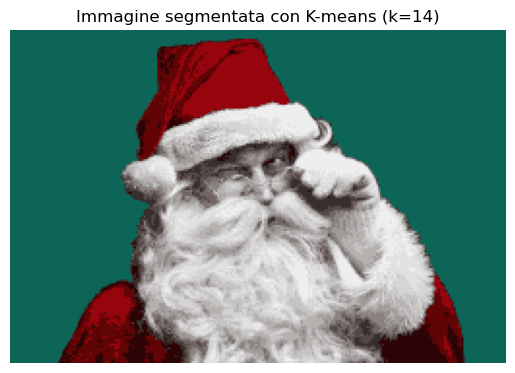


K = 15


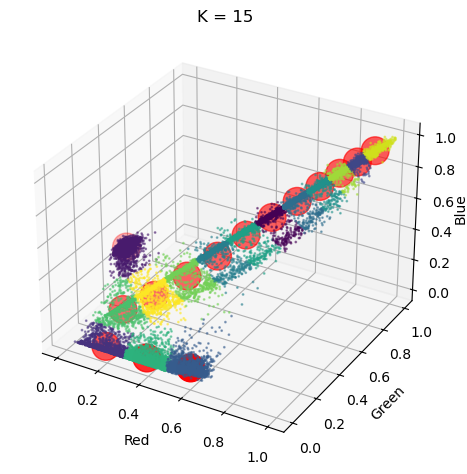

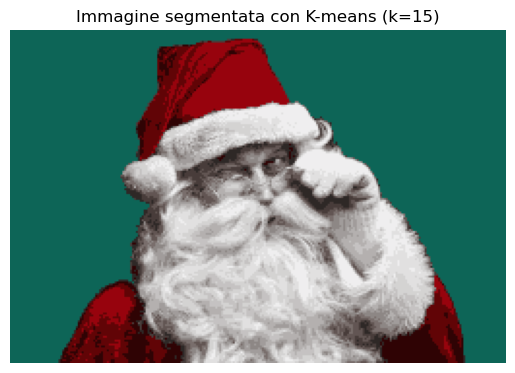

In [40]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Reshape the data to a matrix of total_num_pixels x 3
pixels = data.reshape(-1, 3)
if pixels.max() > 1.0:
    pixels = pixels / 255.0

# Print shape, min, max
print("Shape dei pixel:", pixels.shape)
print("Valore minimo:", pixels.min())
print("Valore massimo:", pixels.max())

# Clustering con diversi valori di K
print('\nK-means clustering with different values of K (2-15):')
inertia = []

for k in range(2, 16):
    print(f"\nK = {k}")
    
    # Define the K-means model
    model = KMeans(n_clusters=k, random_state=42)

    # Fit the model to the data
    model.fit(pixels)

    # Get the cluster centers
    centers = model.cluster_centers_

    # Extract the color values of the centers
    recolored_pixels = centers[model.labels_]

    # Reshape the data to the original image shape
    recolored_image = recolored_pixels.reshape(data.shape)

    # Update the inertia (sum of squared distances to closest cluster center)
    inertia.append(model.inertia_)

    # Plot the scatter plot in RGB space
    scatter_plot(pixels, clusters=model.labels_, centers=centers, title=f"K = {k}")

    # Plot the recolored image
    plt.imshow(recolored_image)
    plt.axis('off')
    plt.title(f"Immagine segmentata con K-means (k={k})")
    plt.show()
    

### TO DO (A.7)

Plot for different values of k (e.g. k between 2 and 15) the respective error of the kmeans algorithm 

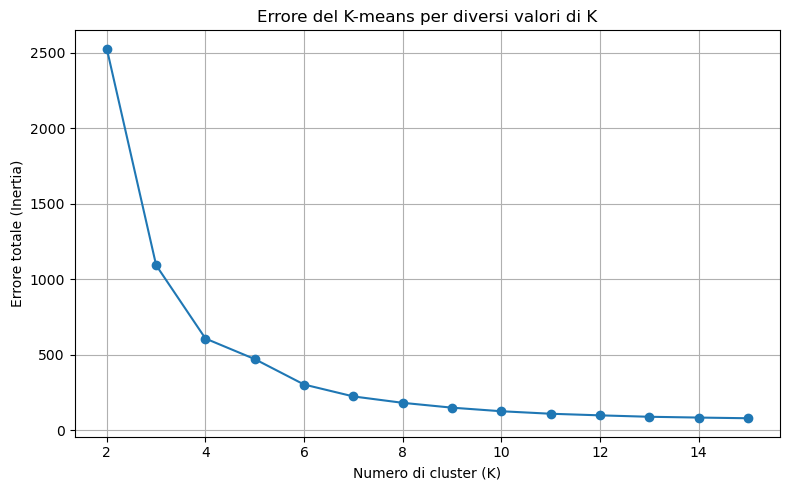

In [41]:
# ADD YOUR CODE HERE
plt.figure(figsize=(8, 5))
plt.plot(range(2, 16), inertia, marker='o')
plt.xlabel("Numero di cluster (K)")
plt.ylabel("Errore totale (Inertia)")
plt.title("Errore del K-means per diversi valori di K")
plt.grid(True)
plt.tight_layout()
plt.show()

### TO DO (AQ.2) [Answer the following]

Compare the results with different values of k, what do you observe? 

Analyze also the error, which one do you think is the optimal value of k?

Is there a single, clear answer?

**ANSWER A.Q2:** Answer here piu cluster faccio piu l'errore scende ovviamente perchè do più spazio ai pixels per cercare i cluster che più riescono ad sintetizzarli

---

## B) Linkage-based clustering

The second part of the assignment concern instead linkage-based clustering. We will use the AgglomerativeClustering module of sklearn. 

### TO DO (B.0)

Load the sample dataset located at `data/moon_data.npz`

In [44]:


# Load sample data (supponiamo si chiami 'sample_data.npz')
data = np.load("data/moon_data.npz")  # Inserisci qui il percorso corretto

# Extract data
x = data['X']
labels_true = data['labels_true']

### TO DO (B.1)

Now exploit the AgglomerativeClustering algorithm from sklearn on the provided sample data points. Use the "single" linkage type that correspond to the minimum distance criteria seen in the lectures and 2 clusters. Notice that the "single" option has been introduced recently in sklearn, if you get an error ensure you have a recent version of the library. Plot the resulting clustering.

In [45]:
# Define the Agglomerative Clustering model
agg_model = AgglomerativeClustering(n_clusters=3)  # Cambia il numero di cluster se necessario

# Fit the model to the data
agg_model.fit(x)

# Compute the number of clusters (ignoring noise if present — AgglomerativeClustering non etichetta "noise" come DBSCAN, quindi possiamo fare solo n_clusters distinti)
labels = agg_model.labels_
n_clusters_ = len(np.unique(labels))

# Print the results
print(f"Numero di cluster trovati: {n_clusters_}")
print("Etichette dei cluster:", labels)

Numero di cluster trovati: 3
Etichette dei cluster: [2 1 2 ... 0 2 2]


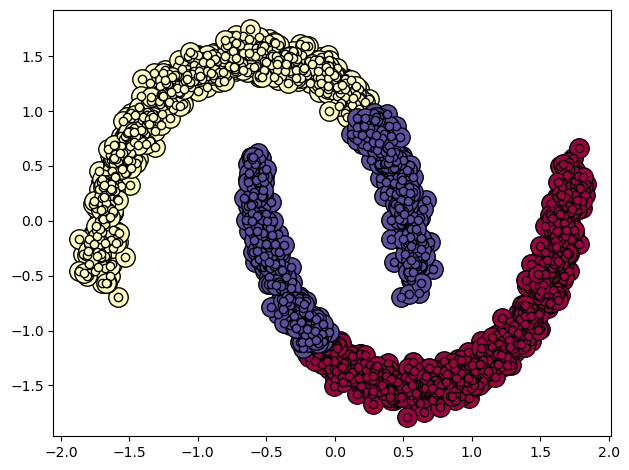

In [48]:
# Plot the clustering result
cluster_plot(labels, x)

### TO DO (B.2)

Now try the KMeans with two clusters on the same dataset we used for the AgglomerativeClustering algorithm.

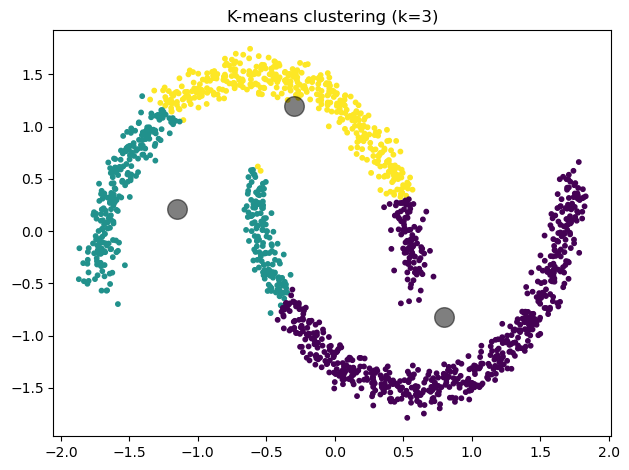

In [50]:
# Define the K-means model
k = 3  # o un altro valore di K
model = KMeans(n_clusters=k, random_state=42)

# Fit the model to the data
model.fit(x)

# Get the cluster centers
centers = model.cluster_centers_

# Extract the color values of the centers (non serve realmente, basta usare le etichette)
labels = model.labels_

# Plot the results
scatter_plot_2d(x, y=labels, centers=centers, title=f"K-means clustering (k={k})")

### TO DO (B.Q1) [Answer the following]

Compare the results of K-means and Agglomerative Clustering and explain what you observe and why?

**ANSWER B.Q1:** Answer here

 non sono simili perchè nel kmeans si distribuiscono centricmente intorno al cluster piu vicino